In [ ]:
import matplotlib.pyplot as plt
from skimage import io, color
import numpy as np
from scipy.interpolate import interp2d

## Part 1.

### Initials

In [ ]:
black = 150
saturation = 4095
r_scale = 2.393118 
g_scale = 1.000000 
b_scale = 1.223981

In [ ]:
def linearizarion(img):
    img_linear = (img - black) / (saturation - black)
    img_linear = np.clip(img_linear, 0, 1)

    return img_linear

In [ ]:
def bayer_pattern(img, pattern='rggb'):
    H, W = img.shape[:2]
    # RGGB Bayer Pattern
    red_mask = np.zeros_like(img)
    green_mask1 = np.zeros_like(img)   
    green_mask2 = np.zeros_like(img)
    blue_mask = np.zeros_like(img)
    red_mask[::2,::2] = 1
    green_mask1[::2,1::2] = 1
    green_mask2[1::2,::2] = 1
    blue_mask[1::2,1::2] = 1
    
    red_channel = img * red_mask
    green1_channel = img * green_mask1
    green2_channel = img * green_mask2
    blue_channel = img * blue_mask
    
    # down-sample
    red_channel = red_channel[::2, ::2]
    green1_channel = green1_channel[::2, 1::2]
    green2_channel = green2_channel[1::2, ::2]
    blue_channel = blue_channel[1::2, 1::2]
    
    return red_channel, green1_channel, green2_channel, blue_channel

In [ ]:
def white_balancing_ww(red_channel, green1_channel, green2_channel, blue_channel):
    # compute mean of each channel
    avg_r = np.mean(red_channel)
    avg_g1 = np.mean(green1_channel)
    avg_g2 = np.mean(green2_channel)
    avg_b = np.mean(blue_channel)

    max_avg = max(avg_r, avg_g1, avg_g2, avg_b)

    scale_r = max_avg / avg_r
    scale_g1 = max_avg / avg_g1
    scale_g2 = max_avg / avg_g2
    scale_b = max_avg / avg_b

    red_channel = red_channel * scale_r
    green1_channel = green1_channel * scale_g1
    green2_channel = green2_channel * scale_g2
    blue_channel = blue_channel * scale_b

    return red_channel, green1_channel, green2_channel, blue_channel

In [ ]:
def demosaic(img, channel, c_row, c_col):
    h, w = img.shape[:2]
    rows = np.arange(c_row, h, 2)
    cols = np.arange(c_col, w, 2)
    y, x = np.arange(h), np.arange(w)
    
    interpolator = interp2d(cols, rows, channel)
    
    return interpolator(x, y) 

In [ ]:
def color_correction(img):
    sRGB2XYZ = np.array([[0.4124564, 0.3575761, 0.1804375],
                          [0.2126729, 0.7151522, 0.0721750],
                          [0.0193339, 0.1191920, 0.9503041]]) 

    XYZ2cam = np.array([[6988, -1384, -714],
                        [-5631, 13410, 2447],
                        [-1485, 2204, 7318]]) / 10000

    # Equation (2)
    sRGB2cam = np.dot(XYZ2cam, sRGB2XYZ)
    # normalize
    sRGB2cam_row_sums = sRGB2cam.sum(axis=1)
    sRGB2cam_norm = sRGB2cam / sRGB2cam_row_sums[:, np.newaxis]

    H, W = img.shape[:2]
    corrected_image = np.zeros_like(img)
    sRGB2cam_inv = np.linalg.inv(sRGB2cam_norm)
   
    for i in range(H):
        for j in range(W):
            RGB = img[i, j]
            sRGB = np.dot(sRGB2cam_inv, RGB)
            corrected_image[i, j] = sRGB

    return corrected_image

In [ ]:
def gamma_encoding(img, gamma=2.4):
    img = np.where((img<=0.0031308), img*12.92, (1+0.055)*pow(img, 1/gamma)-0.055)

    return img

### Read image

In [ ]:
img = io.imread('campus.tiff')
img = img.astype(np.float64)

### Linearization

In [ ]:
img_linear = linearizarion(img)

### Bayer pattern: RGGB

In [ ]:
# divided to 4 channels: red, green1, green2, blue
red_channel, green1_channel, green2_channel, blue_channel = bayer_pattern(img_linear, pattern='rggb')

### white balancing

In [ ]:
# white world automatic white balancing
red_channel, green1_channel, green2_channel, blue_channel = white_balancing_ww(red_channel, green1_channel, green2_channel, blue_channel)

### Demosaicing

<ipython-input-6-3dade2b6a979>:7: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  interpolator = interp2d(cols, rows, channel)
<ipython-input-6-3dade2b6a979>:9: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularG

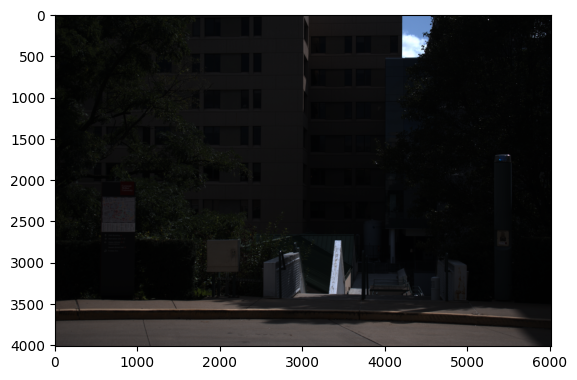

In [ ]:
# Demosaicing for each channel
r = demosaic(img_linear, red_channel, 0, 0) 
g1 = demosaic(img_linear, green1_channel, 0, 1) 
g2 = demosaic(img_linear, green2_channel, 1, 0)    
b = demosaic(img_linear, blue_channel, 1, 1) 
g = (g1 + g2) / 2

img_demosaic = np.dstack((r, g, b))
plt.imshow(img_demosaic)

### Color space correction

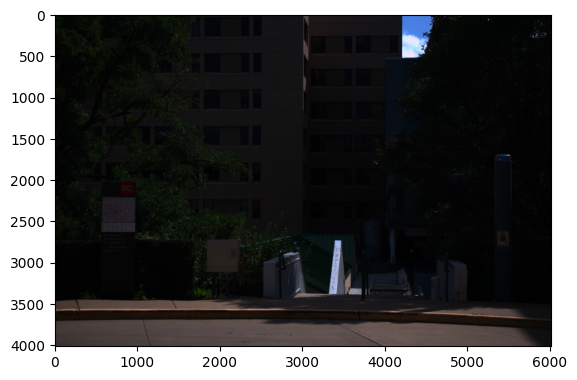

In [ ]:
img_sRGB = color_correction(img_demosaic)
img_sRGB = np.clip(img_sRGB, 0, 1)
plt.imshow(img_sRGB)

### Gamma encoding

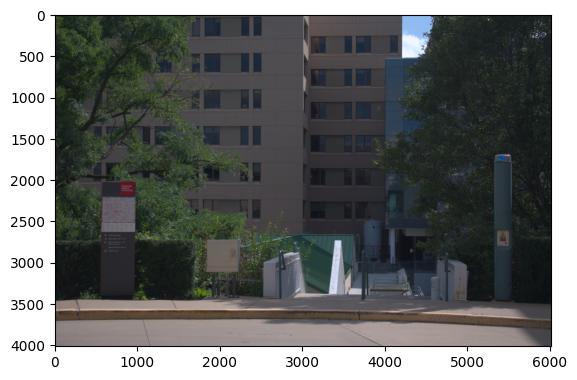

In [ ]:
img_final = gamma_encoding(img_sRGB, gamma=2.4)
plt.imshow(img_final)

### Save as .png

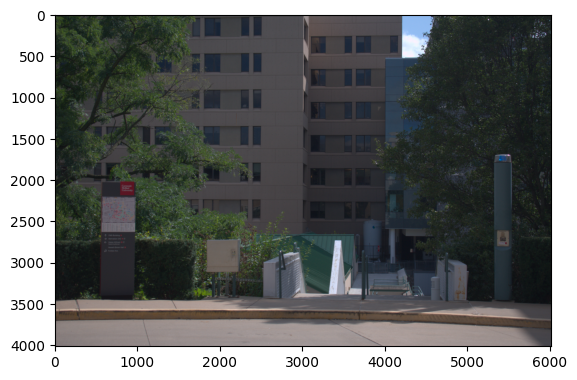

In [ ]:
img_final = img_final * 255
img_final = img_final.astype(np.uint8)
plt.imshow(img_final)
io.imsave('campus.png', img_final)

## Part 2.

In [ ]:
def gamma_correction(img, c=1, g=1.2): #2.2
    out = img.copy()
    out = out/255
    out = (1/c * out) ** (1/g)
    out *= 255
    out = np.uint8(out)

    return out

In [ ]:
def contrast_adjustment(img, contrast=25, brightness=0):
    output = img * (contrast/127 + 1) - contrast + brightness 
    output = np.clip(output, 0, 255)
    output = np.uint8(output)

    return output

In [ ]:
def brightness(img, f=0.25):
    mean_intensity = np.mean(img)

    # Compute scaling factor to set mean intensity to 0.5
    scaling_factor = f / mean_intensity
    brightened_image = img * scaling_factor

    brightened_image = np.clip(brightened_image, 0, 255)

    return brightened_image

In [ ]:
def saturation_adjustment(img, saturation_factor):
    hsv_img = color.rgb2hsv(img)
    hsv_img[..., 1] = np.clip(hsv_img[..., 1] * saturation_factor, 0, 1)
    output_img = color.hsv2rgb(hsv_img)

    return output_img

### Read image

In [ ]:
img = io.imread('campus.png')

### Color correction

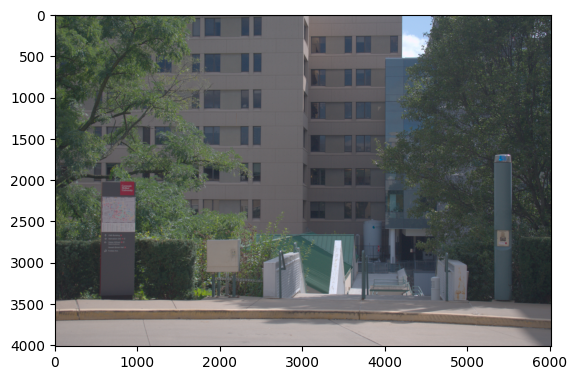

In [ ]:
img_gamma = gamma_correction(img, 1, 1.4)
plt.imshow(img_gamma)

### Contrast adjustment

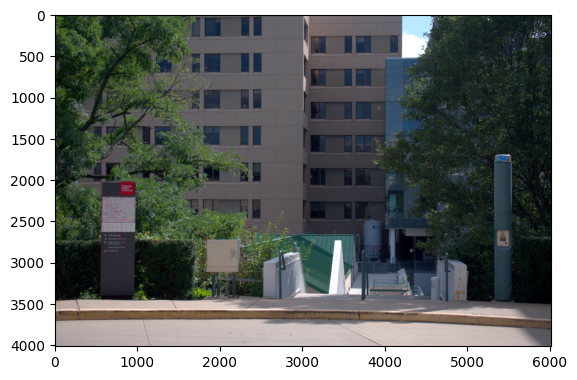

In [ ]:
img_contrast = contrast_adjustment(img_gamma, 50, 0)
plt.imshow(img_contrast)

### Brightness adjustment

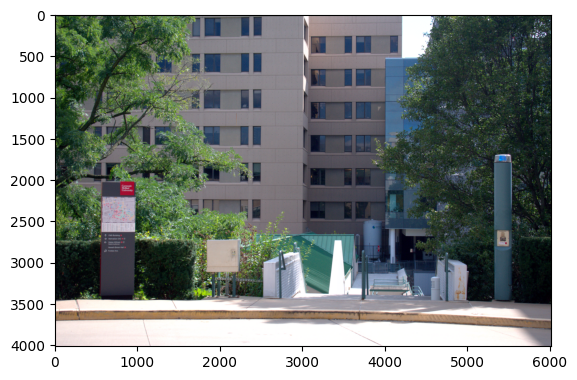

In [ ]:
img_bright = brightness(img_contrast, 0.4)
plt.imshow(img_bright)

### Saturation adjustment

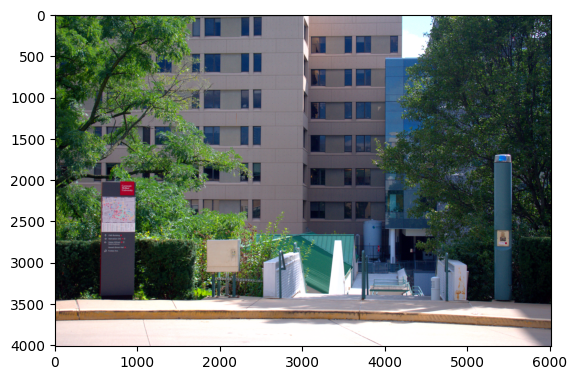

In [ ]:
img_sat = saturation_adjustment(img_bright, 1.3)
plt.imshow(img_sat)
io.imsave('campus2.png', img_sat)